In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [2]:
import os, os.path
from subprocess import getoutput
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
import cv2
#Data visualization
import seaborn as sns
from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import time
import math

from collections import Counter
from collections import defaultdict
from collections import OrderedDict

from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods.py /content
!rm -rf NN_modules

Cloning into 'NN_modules'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 122 (delta 18), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (122/122), 2.81 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [5]:
import Defining_Methods as my_lib

##Definizione import db (per test al 40%)

In [6]:
def get_dataset_crop(db, _batch_size, _dim1, _dim2, drive):

  if db == '9k':
    #%cd /content
    os.chdir("/content")
    downloaded = drive.CreateFile({'id':"1nderD97u_2d1I6TE3ey8wBtEWqLAosk4"})
    downloaded.GetContentFile('data_9400_88.zip')
    #!rm -rf DB_Repo
    getoutput("rm -rf DB_Repo")
    #!unzip -q data_9400_88.zip -d DB_Repo/
    getoutput("unzip -q ddefaultdictata_9400_88.zip -d DB_Repo/")

  elif db == '14k':
    #%cd /content
    os.chdir("/content")
    downloaded = drive.CreateFile({'id':"1z5J7XE_KJYzZGJd-NHX8PUggED2ZK8HG"})
    downloaded.GetContentFile('data.zip')
    #!rm -rf DB_Repo
    getoutput("rm -rf DB_Repo")
    #!unzip -q data.zip -d DB_Repo/
    getoutput("unzip -q data.zip -d DB_Repo/")

  elif db == '18k':
    #%cd /content
    os.chdir("/content")
    downloaded = drive.CreateFile({'id':"18ESID3MpwG-SzZPE1EENzsGPh8vl8ti9"})
    downloaded.GetContentFile('data_18800.zip')
    #!rm -rf DB_Repo
    getoutput("rm -rf DB_Repo")
    #!unzip -q data_18800.zip -d DB_Repo/
    getoutput("unzip -q data_18800.zip -d DB_Repo/")

  else:
    raise ValueError("Keyword for database not recognized; use '9k', '14k' or '18k'.")
  
  path, dirs, files = next(os.walk("/content/DB_Repo/data"))
  file_count = len(files)
  print(file_count)
  #%cd /content/DB_Repo/data
  os.chdir("/content/DB_Repo/data")

  ##PARAMETERS

  dim1 = _dim1
  dim2 = _dim2

  total_pixels = dim1 * dim2
  MAX_LEN = 64 #fisso

  #Considero il primo 1% della lista di dati come test set
  test_percentage = 1 #%
  #Considero il 40% della lista di dati - esclusi i dati di test - come validation set
  validation_percentage = 40 #%

  #COSTANTI E DICHIARAZIONI

  database_list = list()
  labels_list = list()
  obf_list = list()

  #LETTURA E RESIZE IMMAGINI

  print("START IMAGE INPUT")
  #Aggiungo i valori alle liste leggendo i vari files
  for filename in glob.glob('*.npy'):
    temp_img = np.load(filename)
    temp_img = temp_img.reshape((-1, MAX_LEN)).astype(np.uint16)
    #flattening
    temp_img = temp_img.flatten()
    dimensione = temp_img.size

    #padding fino alla dimensione dim1xdim2
    #o crop fino a dim1xdim2 pixels
    if dimensione < total_pixels:
      temp_img = np.pad(temp_img, (0, total_pixels - dimensione), mode='constant',constant_values=0)
    elif dimensione >= total_pixels:
      temp_img = temp_img[0:total_pixels]
    else:
      raise ValueError("Error in reading images.")

    temp_img = temp_img.reshape((dim1, dim2))
    database_list.append(temp_img)
    #Salvo la label, ossia la classe
    labels_list.append(my_lib.extract_label(filename))
    #Salvo la lista di offuscatori di ogni file
    obf_list.append(my_lib.extract_obf(filename))
  print("END IMAGE INPUT")

  #SHUFFLE

  #Ho i valori e le etichette in due liste (+ obf); 
  #le mescolo mantenendo l'ordine tra valore-label
  temp = list(zip(database_list, labels_list, obf_list))
  np.random.shuffle(temp)
  database_list, labels_list, obf_list = zip(*temp)

  #SUDDIVISIONE DATI
  #Suddivido in training set, test set e validation test
  assert len(database_list) == len(labels_list) == len(obf_list)
  #print(len(database_list))

  #Split per creare test set
  index_to_split = math.ceil((len(database_list) * test_percentage) / 100)
  indices = [(0, index_to_split - 1), (index_to_split, len(database_list) - 1)]

  test_list, training_list = [database_list[s:e+1] for s,e in indices]
  labels_test_list, labels_training_list = [labels_list[s:e+1] for s,e in indices]
  obf_test_list, obf_training_list = [obf_list[s:e+1] for s,e in indices]

  #Split per creare validation set
  index_to_split = math.ceil((len(training_list) * validation_percentage) / 100)
  indices = [(0, index_to_split - 1), (index_to_split, len(training_list) - 1)]

  validation_list, training_list = [training_list[s:e+1] for s,e in indices]
  labels_validation_list, labels_training_list = [labels_training_list[s:e+1] for s,e in indices]
  obf_validation_list, obf_training_list = [obf_training_list[s:e+1] for s,e in indices]

  #Trasformo i valori in numpy.ndarray
  train_images = np.array(training_list)
  test_images = np.array(test_list)
  validation_images = np.array(validation_list)

  train_labels = np.array(labels_training_list)
  test_labels = np.array(labels_test_list)
  validation_labels = np.array(labels_validation_list)

  train_obf = np.array(obf_training_list)
  test_obf = np.array(obf_test_list)
  validation_obf = np.array(obf_validation_list)

  #Encoding delle labels;
  #Se nella suddivisione il 100% di una classe è fuori dal train_labels,
  #Vi sarà un errore nell'encoding delle labels negli altri set.
  label_encoder = LabelEncoder()
  label_encoder.fit(train_labels)
  train_labels_encoded = label_encoder.transform(train_labels)
  test_labels_encoded = label_encoder.transform(test_labels)
  validation_labels_encoded = label_encoder.transform(validation_labels)

  #Normalizzazione valori in range 0-1
  train_images = train_images / 65535.0
  test_images = test_images / 65535.0
  validation_images = validation_images / 65535.0

  #Dichiarazione altri parametri
  n_classes = len(list(label_encoder.classes_))

  sets_and_labels = (train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded)
  numpy_arrays = (train_obf, test_obf, validation_obf)
  return sets_and_labels, numpy_arrays, label_encoder, n_classes

#Parametri modello 64x128

In [7]:
database_scelto = '18k' #or '14k' or '9k'

dim1 = 128
dim2 = 64
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 150
patience = 15

In [8]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

18800
START IMAGE INPUT
END IMAGE INPUT


In [9]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

In [10]:
print(len(train_images))
print(len(test_images))
print(len(validation_images))

11167
188
7445


##Modello

In [11]:
modelLSTM, hist, time_callback = my_lib.modelLSTM(num_units1, num_units2, time_steps, n_features, batch_size, n_classes, patience, sub_db, n_epochs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##Risultati modello

In [12]:
number_of_epochs_it_ran = len(hist.history['loss'])

#time_per_epoch = time_callback.times
#total_time = sum(time_per_epoch)

test_accuracy = modelLSTM.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
#print(str(total_time), "s")

7445/7445 [==============================] - 10s 1ms/sample - loss: 0.4826 - acc: 0.9087
Total epochs 144


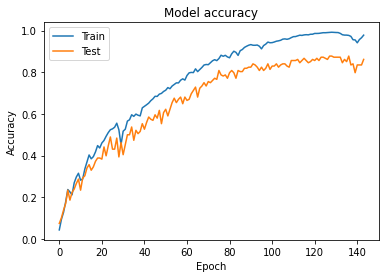

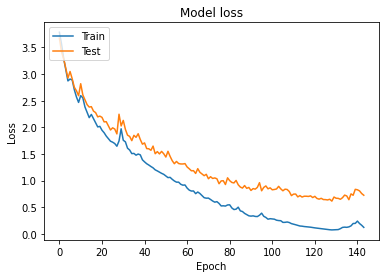

In [13]:
plt.show(my_lib.plot_model_acc(hist))
plt.show(my_lib.plot_model_loss(hist))

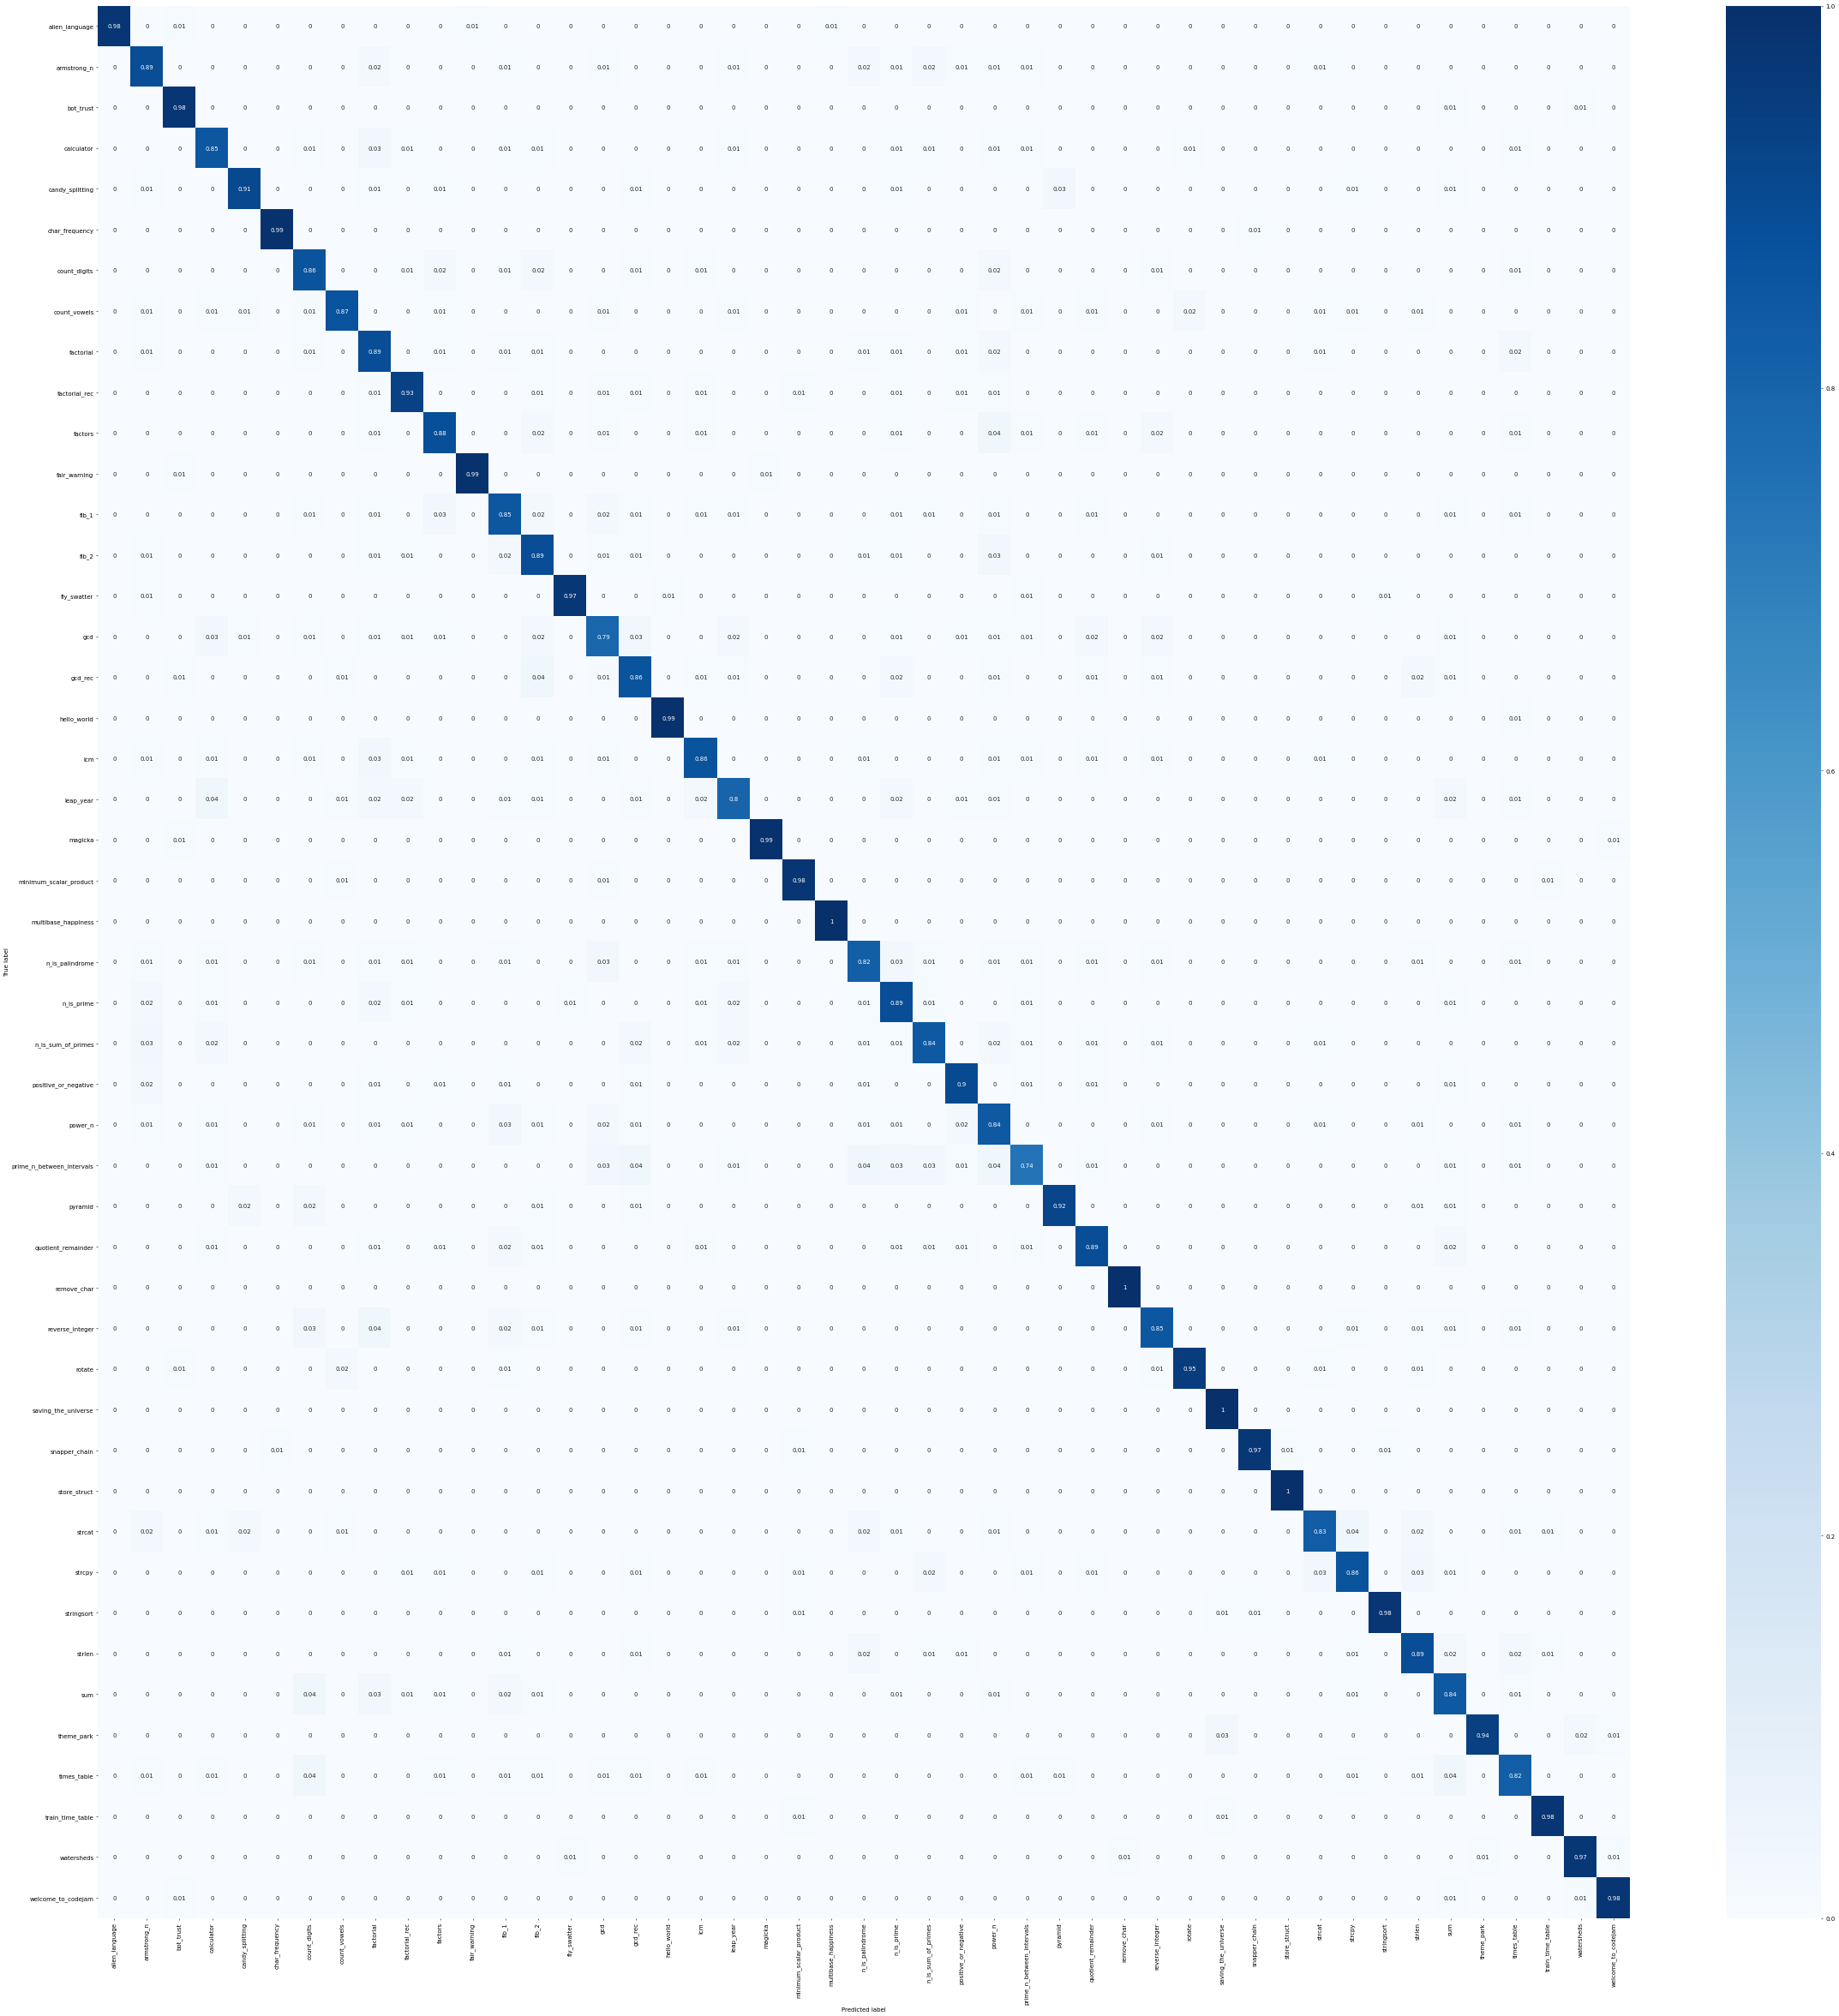

In [14]:
plt.show(my_lib.plot_conf_matrix(modelLSTM, validation_images, validation_labels_encoded, label_encoder))

In [15]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelLSTM, validation_images, validation_labels_encoded, validation_obf, label_encoder)

'''
print("Grafo degli errori focalizzato sul singolo set di offuscamento")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
plt.show(my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori per classe")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue"))
print()
print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
plt.show(my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))
'''

'\nprint("Grafo degli errori focalizzato sul singolo set di offuscamento")\nplt.show(my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue"))\nprint()\nprint("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d\'applicazione")\nplt.show(my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))\nprint()\nprint("Grafo degli errori per classe")\nplt.show(my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue"))\nprint()\nprint("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")\nplt.show(my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))\n'

In [16]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('Flatten-RandomFuns-Split', 61)
('EncodeArithmetic-Flatten-RandomFuns', 57)
('InitEntropy-InitOpaque-RandomFuns', 42)
('EncodeLiterals-InitOpaque-Split', 41)
('EncodeArithmetic-Flatten-Split', 35)
('EncodeLiterals-InitEntropy-InitOpaque', 34)
('EncodeLiterals-Flatten-InitOpaque', 33)
('EncodeArithmetic-RandomFuns-Split', 31)
('EncodeLiterals-Flatten-Split', 28)
('EncodeLiterals-RandomFuns-Split', 27)
('EncodeLiterals-Flatten-RandomFuns', 25)
('EncodeLiterals-InitOpaque-RandomFuns', 24)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 24)
('Flatten-InitEntropy-InitOpaque', 23)
('InitOpaque-RandomFuns-Split', 19)
('EncodeArithmetic-InitEntropy-InitOpaque', 17)
('Flatten-InitOpaque-RandomFuns', 17)
('EncodeArithmetic-EncodeLiterals-Split', 15)
('base', 14)
('Flatten-InitOpaque-Split', 14)
('EncodeArithmetic-Flatten-InitOpaque', 13)
('EncodeArithmetic-EncodeLiterals-RandomFuns', 13)
('EncodeArithmetic-EncodeLiterals-Flatten', 12)
('EncodeArithmetic-InitOpaque-RandomFuns', 11)
('InitEntropy-

In [17]:
'''ordered_completo = my_lib.order_dict_of_dict(completo)
print("Classi - percentuale su tutto test set; aggiunti i 0%")
#my_lib.stampa_percent_classeXobf(ordered_completo)

ordered_completo_alf = collections.OrderedDict(sorted(ordered_completo.items()))
my_lib.stampa_percent_classeXobf(ordered_completo_alf)'''

'ordered_completo = my_lib.order_dict_of_dict(completo)\nprint("Classi - percentuale su tutto test set; aggiunti i 0%")\n#my_lib.stampa_percent_classeXobf(ordered_completo)\n\nordered_completo_alf = collections.OrderedDict(sorted(ordered_completo.items()))\nmy_lib.stampa_percent_classeXobf(ordered_completo_alf)'

In [18]:
'''
ordered_tot = my_lib.order_dict_of_dict(percent_wr_classeXobf_tot)
print("Classi - percentuale su tutto test set")
my_lib.stampa_percent_classeXobf(ordered_tot)
'''

'\nordered_tot = my_lib.order_dict_of_dict(percent_wr_classeXobf_tot)\nprint("Classi - percentuale su tutto test set")\nmy_lib.stampa_percent_classeXobf(ordered_tot)\n'

#Estrazione offuscamenti di una classe

In [19]:
'''
lista = list()
for k in wr_classeXobfs_ERR.get("theme_park"):
  lista.append(k)

listaaa= list()
for elem in lista:
  separator = '-'
  temp_list = elem.split(separator)  
  temp_list.sort()
  temp_list = separator.join(temp_list)

  listaaa.append(temp_list)
conto = Counter(listaaa)
'''

'\nlista = list()\nfor k in wr_classeXobfs_ERR.get("theme_park"):\n  lista.append(k)\n\nlistaaa= list()\nfor elem in lista:\n  separator = \'-\'\n  temp_list = elem.split(separator)  \n  temp_list.sort()\n  temp_list = separator.join(temp_list)\n\n  listaaa.append(temp_list)\nconto = Counter(listaaa)\n'

In [20]:
'''
conto
'''

'\nconto\n'

In [21]:
import os, os.path
from subprocess import getoutput

import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
import cv2
#Data visualization
import seaborn as sns
from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import time
import math

from collections import Counter
from collections import defaultdict
from collections import OrderedDict

In [22]:
import itertools
import collections
import statistics

In [23]:
###############################################
#On all validation set, building dictionary class - single obf
#then dictionary ( class - ( obf - number occurences) )
val_classXobfs = defaultdict(list)
validation_classes = list()

#Using validation_labels_encoded for iterating on validation set
for index in range(len(validation_labels_encoded)):
  val_label = validation_labels_encoded[index]
  class_name_arr = label_encoder.inverse_transform([val_label])
  assert len(class_name_arr) == 1
  class_name = class_name_arr[0]
  validation_classes.append(class_name)
  val_classXobfs[class_name].append(validation_obf[index])

val_obf_set = set()
val_classXObf_singolo = defaultdict(list)
for val_classe, offuscamenti in val_classXobfs.items():
  single_obf_temp = list()
  #offuscamenti è tutti gli offuscamenti abc di una classe k
  #lista_obf corrisponde ad una singola sequenza abc di offuscamenti.
  #Separo abc in a, b, c.
  for lista_obf in offuscamenti:
    temp_list = lista_obf.split('-')
    for singolo_obf in temp_list:
      single_obf_temp.append(singolo_obf)
  for elem in single_obf_temp:
    val_obf_set.add(elem)
    val_classXObf_singolo[val_classe].append(elem)

count_val_classeXobf_singolo = defaultdict(dict)
for classe, lista_obf in val_classXObf_singolo.items():
  conto = dict(Counter(lista_obf))
  for obf, numero in conto.items():
    count_val_classeXobf_singolo[classe].update({obf : numero})

#####

#The single obf in all validation set (not only the wrong classified)
single_obfs_total = list()
for elem in validation_obf:
  temp_list = elem.split('-')
  for sub_elem in temp_list:
    single_obfs_total.append(sub_elem)
  
count_single_obfs_total = Counter(single_obfs_total)
###############################################
###############################################
#On wrong test

#returns a list of indexes; each one indicates a test wrongly classified
incorrects_temp = np.nonzero(modelLSTM.predict_classes(validation_images) != validation_labels_encoded)
#manipulation to have a clear list
incorrects = list()
for elem in incorrects_temp[0]:
  incorrects.append(elem)

#Trasforming the list of indexes in the corresponding
#list of wrong classes (labels)
#list of wrong obfuscations
#dict of classes : list of obfuscations (each wrong classified class with the corresponding obf transformations)
wrong_classes = list()
wrong_obf = list()
wr_classeXobfs_ERR = defaultdict(list)

for index in incorrects:

  #class_name_arr contains a numpy_ndarray of 1 elem that contains the class name
  class_name_arr = label_encoder.inverse_transform([validation_labels_encoded[index]])
  assert len(class_name_arr) == 1
  class_name = class_name_arr[0]
  wrong_classes.append(class_name)

  obfs_of_wrong_class = validation_obf[index]
  wrong_obf.append(obfs_of_wrong_class)
  wr_classeXobfs_ERR[class_name].append(obfs_of_wrong_class)

###############################################

assert len(wrong_classes) == len(wrong_obf)

#Ordering the single obf in the list of obfs
#i.e., b-c-a becomes a-b-c; a-c-b becomes a-b-c
ordered_wr_obfs = list()
for elem in wrong_obf:
  separator = '-'
  temp_list = elem.split(separator)  
  temp_list.sort()
  temp_list = separator.join(temp_list)
  ordered_wr_obfs.append(temp_list)

#The single obf in the wrong-classified list
single_wr_obf = list()
for elem in wrong_obf:
  temp_list = elem.split('-')
  for sub_elem in temp_list:
    single_wr_obf.append(sub_elem)

###############################################

count_wrong_classes = Counter(wrong_classes)
count_wrong_obf = Counter(wrong_obf)
count_ordered_wr_obfs = Counter(ordered_wr_obfs)

count_wr_single_obf = Counter(single_wr_obf)

###

single_wr_obf_percentage = dict()
for key, value in count_single_obfs_total.items():
  error_val = count_wr_single_obf.get(key)
  if type(error_val)==None.__class__:
    percentage = 0
  else:
    percentage = (100 * error_val) / value
  percentage = round(percentage, 2)
  single_wr_obf_percentage.update({key : percentage})

#######################

#dizionario(k, v) dove k è la classe, v è una lista di offuscamenti singolarmente divisi
wr_classXObf_singolo = defaultdict(list)
for k, offuscamenti in wr_classeXobfs_ERR.items():
  single_obf_temp = list()
  #offuscamenti è tutti gli offuscamenti abc di una classe k
  #lista_obf corrisponde ad una singola sequenza abc di offuscamenti.
  #Separo abc in a, b, c.
  for lista_obf in offuscamenti:
    temp_list = lista_obf.split('-')
    for singolo_obf in temp_list:
      single_obf_temp.append(singolo_obf)
  for elem in single_obf_temp:
    wr_classXObf_singolo[k].append(elem)

count_wr_classXObf_singolo = defaultdict(dict)
for classe, lista_obf in wr_classXObf_singolo.items():
  conto = dict(Counter(lista_obf))
  for obf, numero in conto.items():
    count_wr_classXObf_singolo[classe].update({obf : numero})


percent_wr_classeXobf_tot = defaultdict(dict)
for classe, obf_wr_contati in count_wr_classXObf_singolo.items():
  for obf, numero in obf_wr_contati.items():
    #Recupero il conto degli offuscamenti della classe in esame
    #dalla lista di offuscamenti contati su tutto il test set (validation set)
    val_classe = count_val_classeXobf_singolo.get(classe)
    #Recupero il numero di occorrenze di quel preciso offuscamento
    #tramite la quale calcolerò la percentuale (genero il valore totale)
    valid_tot = val_classe.get(obf)    
    percentage = (100 * numero) / valid_tot
    percentage = round(percentage, 2)
    percent_wr_classeXobf_tot[classe].update({obf : percentage})


###ottimizzabile
ordered_set_obfs = count_wr_single_obf.most_common()
obf_set = set()
for elem in ordered_set_obfs:
  obf_set.add(elem[0])
###

completo = defaultdict(dict)
for classe, diz in percent_wr_classeXobf_tot.items():
  local_set = set()
  diff = set()
  for obf, val in diz.items():
    local_set.add(obf)
    completo[classe].update( { obf : val} ) #aggiungo il valore che già c'era

  diff = obf_set - local_set
  for elem in diff:
    #per ogni elem in diff, vuol dire che quell'elem (ossia un offuscamento)
    #non c'era perchè era 0%; lo aggiungo
    completo[classe].update( {elem : 0} ) 

##Pair check

In [24]:
#Ordino gli offuscamenti

#dizionario che contiene
#k classe
#v lista di offuscamenti ordinata
#i valori contenuti si riferiscono ai test falliti
classe_obfsOrdin_wr = defaultdict(list)
for classe, obfs in wr_classeXobfs_ERR.items():
  ordinato = my_lib.ordina_obfs(obfs) #lista
  #per non inizializzare una lista di liste,
  #faccio append di una stringa alla volta nella lista del valore k
  for elem in ordinato:
    classe_obfsOrdin_wr[classe].append(elem)

In [25]:
coppie_wr = defaultdict(list)

for classe, v in classe_obfsOrdin_wr.items():
  #devo lavorare per ogni classe
  #nella classe, per ogni obfs
  #fisso il primo, e genero ogni coppia, per ogni obfs, cioè:
  #[abc][asb][ats]
  #fisso a:
  # ab+1; ac+1
  # cerco queste coppie negli altri
  # ab: c'è asb->as (ignorato); ab -> ab+1

  for obfs in v:
    temp_list = obfs.split('-')

    #potrei sviluppare un algoritmo più intelligente
    #ma so che:
    #1. gli obf sono in ordine
    #2. non ci sono coppie di obf ripetute
    #3. il numero di obf può essere 1 (pass), 2 o 3

    if len(temp_list) == 1:
      pass
    elif len(temp_list) == 2:
      primo = temp_list[0]
      secondo = temp_list[1]

      coppia1 = (primo, secondo)

      coppie_wr[classe].append(coppia1)
      
    elif len(temp_list) == 3:
      primo = temp_list[0]
      secondo = temp_list[1]
      terzo = temp_list[2]

      coppia1 = (primo, secondo)
      coppia2 = (primo, terzo)
      coppia3 = (secondo, terzo)

      coppie_wr[classe].append(coppia1)
      coppie_wr[classe].append(coppia2)
      coppie_wr[classe].append(coppia3)

    else: #temp_list = 0 OR > 3 error
      raise ValueError("Number of obf in obfs not normal!")

In [26]:
count_coppie_wr = defaultdict(dict)

for classe, coppie in coppie_wr.items():
  conto = dict(Counter(coppie))
  for coppia, numero in conto.items():
    count_coppie_wr[classe].update( {coppia : numero} )

In [27]:
count_coppie_wr_ordin = defaultdict(dict)
for cl, x in count_coppie_wr.items():
  temp_ord = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
  primi_10 = dict(itertools.islice(temp_ord.items(), 10)) #prendo le prime 10 più frequenti
  for k, v in primi_10.items():
    count_coppie_wr_ordin[cl].update( {k : v} )

In [28]:
'''
for coppia, num in count_coppie_wr_ordin.get("armstrong_n").items():
  print(coppia, num)
'''

'\nfor coppia, num in count_coppie_wr_ordin.get("armstrong_n").items():\n  print(coppia, num)\n'

In [29]:
count_coppie_wr_ordin_alf = collections.OrderedDict(sorted(count_coppie_wr_ordin.items()))

In [30]:
ordered_completo = my_lib.order_dict_of_dict(completo)
print("Classi - percentuale su tutto test set; aggiunti i 0%")
#my_lib.stampa_percent_classeXobf(ordered_completo)

ordered_completo_alf = collections.OrderedDict(sorted(ordered_completo.items()))
my_lib.stampa_percent_classeXobf(ordered_completo_alf)

Classi - percentuale su tutto test set; aggiunti i 0%
alien_language := InitOpaque: 6.06%; InitEntropy: 4.55%; Flatten: 3.33%; Split: 3.23%; RandomFuns: 1.56%; InitImplicitFlow: 0%; EncodeLiterals: 0%; EncodeArithmetic: 0%; base: 0%; 
armstrong_n := InitOpaque: 20.0%; RandomFuns: 17.54%; Split: 16.67%; Flatten: 15.09%; EncodeArithmetic: 13.64%; EncodeLiterals: 8.47%; InitEntropy: 3.64%; base: 0%; InitImplicitFlow: 0%; 
bot_trust := base: 100.0%; InitOpaque: 4.26%; EncodeLiterals: 3.77%; RandomFuns: 3.77%; Flatten: 0%; EncodeArithmetic: 0%; InitImplicitFlow: 0%; Split: 0%; InitEntropy: 0%; 
calculator := base: 100.0%; Split: 23.26%; InitOpaque: 21.28%; Flatten: 21.28%; EncodeLiterals: 18.52%; RandomFuns: 15.56%; EncodeArithmetic: 11.11%; InitEntropy: 10.42%; InitImplicitFlow: 0%; 
candy_splitting := base: 100.0%; EncodeLiterals: 22.41%; Split: 14.58%; RandomFuns: 12.0%; InitOpaque: 10.42%; Flatten: 6.82%; InitEntropy: 5.26%; EncodeArithmetic: 1.79%; InitImplicitFlow: 1.61%; 
char_freque

In [31]:
for k, v in count_coppie_wr_ordin_alf.items():
  print(k)
  for kk, vv in v.items():
    print(kk, vv)
  print()

alien_language
('InitEntropy', 'InitOpaque') 3
('InitOpaque', 'Split') 2
('Flatten', 'InitEntropy') 2
('Flatten', 'InitOpaque') 2
('InitEntropy', 'Split') 1
('InitOpaque', 'RandomFuns') 1
('RandomFuns', 'Split') 1

armstrong_n
('EncodeArithmetic', 'Split') 6
('InitOpaque', 'Split') 5
('Flatten', 'RandomFuns') 5
('EncodeArithmetic', 'RandomFuns') 5
('EncodeLiterals', 'InitOpaque') 4
('InitOpaque', 'RandomFuns') 4
('EncodeArithmetic', 'Flatten') 4
('EncodeLiterals', 'Split') 3
('Flatten', 'Split') 3
('RandomFuns', 'Split') 3

bot_trust
('EncodeLiterals', 'InitOpaque') 2
('EncodeLiterals', 'RandomFuns') 2
('InitOpaque', 'RandomFuns') 2

calculator
('EncodeLiterals', 'InitOpaque') 6
('EncodeLiterals', 'Split') 6
('Flatten', 'RandomFuns') 6
('InitEntropy', 'InitOpaque') 5
('InitOpaque', 'Split') 4
('EncodeLiterals', 'Flatten') 4
('Flatten', 'Split') 4
('RandomFuns', 'Split') 4
('Flatten', 'InitOpaque') 3
('EncodeArithmetic', 'InitEntropy') 2

candy_splitting
('EncodeLiterals', 'Split') 7
('

In [32]:
alien_language = [98, 96, 97, 99, 98, 100, 98, 98, 99, 100]
armstrong_n = [84, 80, 87, 81, 85, 82, 88, 82, 92, 79]
bot_trust = [98, 98, 99, 99, 98, 98, 99, 96, 96, 99]
calculator = [84, 88, 94, 93, 89, 90, 91, 90, 87, 84]
candy_splitting = [97, 95, 91, 86, 98, 89, 90, 89, 93, 92]
char_frequency = [96, 97, 99, 99, 96, 97, 95, 94, 99, 99]
count_digits = [88, 82, 87, 84, 87, 85, 89, 92, 86, 83]
count_vowels = [90, 92, 86, 89, 93, 88, 89, 93, 89, 88]
factorial = [88, 85, 87, 88, 89, 86, 89, 82, 84, 84]
factorial_rec = [94, 91, 93, 86, 94, 87, 93, 93, 95, 88]
factors = [84, 88, 80, 87, 86, 85, 83, 87, 83, 84]
fair_warning = [96, 98, 98, 98, 97, 99, 94, 99, 99, 99]
fib_1 = [89, 86, 84, 84, 84, 88, 84, 83, 84, 75]
fib_2 = [84, 90, 84, 88, 86, 80, 82, 87, 90, 83]
fly_swatter = [99, 99, 98, 98, 95, 98, 98, 98, 99, 96]
gcd = [88, 84, 83, 85, 78, 80, 79, 83, 87, 81]
gcd_rec = [85, 86, 92, 85, 88, 91, 93, 93, 90, 83]
hello_world = [99, 100, 99, 98, 99, 99, 96, 97, 99, 100]
lcm = [92, 80, 85, 85, 89, 83, 89, 86, 91, 82]
leap_year = [82, 89, 85, 92, 86, 83, 89, 80, 84, 76]
magicka = [97, 97, 95, 99, 96, 98, 99, 99, 98, 97]
minimum_scalar_product = [96, 98, 99, 92, 94, 96, 96, 98, 96, 97]
multibase_happiness = [98, 99, 96, 98, 99, 100, 98, 100, 99, 99]
n_is_palindrome = [84, 91, 80, 88, 87, 85, 87, 83, 83, 82]
n_is_prime = [79, 82, 88, 88, 83, 83, 86, 82, 87, 74]
n_is_sum_of_primes = [86, 84, 90, 90, 88, 85, 86, 88, 92, 86]
positive_or_negative = [91, 88, 87, 89, 85, 90, 89, 87, 92, 82]
power_n = [89, 81, 80, 91, 85, 83, 84, 84, 90, 75]
prime_n_between_intervals = [84, 87, 89, 89, 87, 87, 89, 87, 87, 80]
pyramid = [92, 92, 90, 95, 85, 96, 93, 92, 95, 84]
quotient_remainder = [90, 89, 91, 85, 86, 92, 88, 90, 95, 83]
remove_char = [99, 99, 99, 96, 99, 99, 95, 97, 97, 99]
reverse_integer = [86, 93, 77, 87, 88, 86, 85, 92, 81, 71]
rotate = [95, 98, 95, 97, 95, 96, 97, 91, 96, 88]
saving_the_universe = [97, 96, 98, 98, 100, 99, 100, 100, 99, 99]
snapper_chain = [98, 99, 98, 99, 96, 96, 97, 98, 97, 96]
store_struct = [98, 98, 97, 99, 96, 98, 95, 96, 98, 96]
strcat = [90, 88, 83, 89, 86, 92, 91, 91, 86, 80]
strcpy = [88, 88, 86, 91, 93, 88, 90, 87, 88, 88]
stringsort = [96, 96, 96, 98, 97, 96, 97, 98, 94, 99]
strlen = [89, 88, 92, 89, 88, 81, 88, 87, 92, 82]
sum = [88, 86, 85, 82, 87, 82, 83, 90, 87, 84]
theme_park = [98, 99, 97, 98, 99, 99, 99, 98, 97, 98]
times_table = [93, 89, 89, 89, 89, 86, 80, 90, 88, 78]
train_time_table = [98, 98, 100, 99, 97, 95, 97, 97, 97, 100]
watersheds = [97, 97, 95, 99, 99, 99, 99, 98, 99, 96]
welcome_to_codejam = [97, 99, 99, 95, 100, 95, 99, 99, 100, 99]

In [33]:
all_classes_stats = dict()

In [34]:
all_classes_stats["alien_language"] = alien_language
all_classes_stats["armstrong_n"] = armstrong_n
all_classes_stats["bot_trust"] = bot_trust
all_classes_stats["calculator"] = calculator
all_classes_stats["candy_splitting"] = candy_splitting
all_classes_stats["char_frequency"] = char_frequency
all_classes_stats["count_digits"] = count_digits
all_classes_stats["count_vowels"] = count_vowels
all_classes_stats["factorial"] = factorial
all_classes_stats["factorial_rec"] = factorial_rec
all_classes_stats["factors"] = factors
all_classes_stats["fair_warning"] = fair_warning
all_classes_stats["fib_1"] = fib_1
all_classes_stats["fib_2"] = fib_2
all_classes_stats["fly_swatter"] = fly_swatter
all_classes_stats["gcd"] = gcd
all_classes_stats["gcd_rec"] = gcd_rec
all_classes_stats["hello_world"] = hello_world
all_classes_stats["lcm"] = lcm
all_classes_stats["leap_year"] = leap_year
all_classes_stats["magicka"] = magicka
all_classes_stats["minimum_scalar_product"] = minimum_scalar_product
all_classes_stats["multibase_happiness"] = multibase_happiness
all_classes_stats["n_is_palindrome"] = n_is_palindrome
all_classes_stats["n_is_prime"] = n_is_prime
all_classes_stats["n_is_sum_of_primes"] = n_is_sum_of_primes
all_classes_stats["positive_or_negative"] = positive_or_negative
all_classes_stats["power_n"] = power_n
all_classes_stats["prime_n_between_intervals"] = prime_n_between_intervals
all_classes_stats["pyramid"] = pyramid
all_classes_stats["quotient_remainder"] = quotient_remainder
all_classes_stats["remove_char"] = remove_char
all_classes_stats["reverse_integer"] = reverse_integer
all_classes_stats["rotate"] = rotate
all_classes_stats["saving_the_universe"] = saving_the_universe
all_classes_stats["snapper_chain"] = snapper_chain
all_classes_stats["store_struct"] = store_struct
all_classes_stats["strcat"] = strcat
all_classes_stats["strcpy"] = strcpy
all_classes_stats["stringsort"] = stringsort
all_classes_stats["strlen"] = strlen
all_classes_stats["sum"] = sum
all_classes_stats["theme_park"] = theme_park
all_classes_stats["times_table"] = times_table
all_classes_stats["train_time_table"] = train_time_table
all_classes_stats["watersheds"] = watersheds
all_classes_stats["welcome_to_codejam"] = welcome_to_codejam

In [35]:
for k, v in all_classes_stats.items():
  print(k + ", " + str(round(statistics.mean(v))) + "%, "  + str(round(statistics.pstdev(v), 3)) + " stdev.")

alien_language, 98%, 1.187 stdev.
armstrong_n, 84%, 3.847 stdev.
bot_trust, 98%, 1.095 stdev.
calculator, 89%, 3.194 stdev.
candy_splitting, 92%, 3.606 stdev.
char_frequency, 97%, 1.758 stdev.
count_digits, 86%, 2.83 stdev.
count_vowels, 90%, 2.193 stdev.
factorial, 86%, 2.272 stdev.
factorial_rec, 91%, 3.072 stdev.
factors, 85%, 2.283 stdev.
fair_warning, 98%, 1.552 stdev.
fib_1, 84%, 3.562 stdev.
fib_2, 85%, 3.2 stdev.
fly_swatter, 98%, 1.249 stdev.
gcd, 83%, 3.156 stdev.
gcd_rec, 89%, 3.499 stdev.
hello_world, 99%, 1.2 stdev.
lcm, 86%, 3.763 stdev.
leap_year, 85%, 4.477 stdev.
magicka, 98%, 1.285 stdev.
minimum_scalar_product, 96%, 1.939 stdev.
multibase_happiness, 99%, 1.114 stdev.
n_is_palindrome, 85%, 3.098 stdev.
n_is_prime, 83%, 4.167 stdev.
n_is_sum_of_primes, 88%, 2.419 stdev.
positive_or_negative, 88%, 2.793 stdev.
power_n, 84%, 4.665 stdev.
prime_n_between_intervals, 87%, 2.615 stdev.
pyramid, 91%, 3.852 stdev.
quotient_remainder, 89%, 3.36 stdev.
remove_char, 98%, 1.446 st